# Tanzania Water Pump Dataset Analysis

The Tanzanian government has worked with for-profit and non-profit organizations to build water pumps across Tanzania to provide its denizens with potable water. These pumps need maintenance to continue to operate. Before the repair teams can be sent, they need to know which pumps need replacement or repair. It is expensive and time-consuming to send teams to all water pumps to determine which are non-functional. The purpose of this dataset analysis is to create a machine learning algorithm that can determine which pumps are non-functional to save the time and money of the Tanzanian government and its cooperative organizations.

This data was from a private Kaggle competition held by BloomTech for its DS36 Data Science cohort; its data mirrors that of the community Kaggle competition.

The evaluation metric of the community competition was AUC; the evaluation metric of the BloomTech competition was classification accuracy. This analysis will be using the latter as its evaluation metric.

## Import Libraries

All libraries used will be consolidated here.

In [ ]:
%pip install category_encoders==2.*

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

## Exploratory Data Analysis (EDA) 1

The data must be loaded, cleaned, and understood before it can be used effectively in a machine learning model. This is a cursory EDA, intended to:
1. Convert ambiguous or incorrect datatypes.
2. Determine null values and convert possible null values (e.g. [0, 0] for longitude and latitude)
3. Determine and remove high cardinality columns.
4. Determine and remove duplicate value columns.


### Load data

In [4]:
# load data into dataframe
df = pd.merge(pd.read_csv('train_labels.csv').set_index('id'),
              pd.read_csv('train_features.csv').set_index('id'),
              left_index=True,
              right_index=True
              )

In [5]:
# view first 5 rows of dataframe
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,functional,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,functional,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,non functional,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,non functional,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,non functional,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [6]:
# dataframe shape
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 47520, Columns: 40


In [7]:
# dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           47520 non-null  object 
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  object 
 3   funder                 44644 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44631 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47520 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47224 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  int64  
 15  

### Convert Incorrect Datatypes

In [8]:
# columns of object type
df.select_dtypes('object').columns

Index(['status_group', 'date_recorded', 'funder', 'installer', 'wpt_name',
       'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [9]:
# columns of non-object type
df.select_dtypes(exclude='object').columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')

'date_recorded' and 'constuction_year' are both datetimes.
- 'date_recorded' is the date the pump's functionality was reported.
- 'construction_year' is the year the pump was constructed.

It is tempting to only use construction year for the analysis and drop 'date_recorded', but comparing the pump year to the current year does not account for possible changes in pump functionality between 'date_recorded' and the current year. These values work in tandem to provide the pump age. Pump age will be created in the feature engineering section, but setting the data types of 'date_recorded' and 'construction_year' now will make it easier to create this variable in the future.

Additionally, because 'construction_year' only measures the year the pump was constructed, and not the exact date, it does not provide an exact comparison to 'date_recorded'. To best account for pump age, 'date_recorded' will be rounded to the nearest year.

In [10]:
# convert 'date_recorded' to datetime
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
# year rounding function
def round_date_to_nearest_year(dt):
    if dt.month <= 6:
        return dt.year
    else:
        return dt.year + 1
# apply rounding function
df['date_recorded'] = df['date_recorded'].map(round_date_to_nearest_year)

print(df['date_recorded'].head())
print(df['construction_year'].head())

id
454      2013
510      2011
14146    2012
47410    2011
1288     2011
Name: date_recorded, dtype: int64
id
454      1998
510         0
14146       0
47410       0
1288     1997
Name: construction_year, dtype: int64


In [11]:
# number of unique values by column
df.nunique()

status_group                 3
amount_tsh                  96
date_recorded                6
funder                    1698
gps_height                2401
installer                 1923
longitude                46043
latitude                 46044
wpt_name                 30742
num_private                 59
basin                        9
subvillage               17232
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2076
population                 971
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2541
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [12]:
df['recorded_by'].unique()

array(['GeoData Consultants Ltd'], dtype=object)

'recorded_by' has a single unique value, so this column can be dropped.

In [13]:
df.drop(columns=['recorded_by'], inplace=True)

Some of the columns have very few values, indicating that these might be boolean columns. Some columns that should be boolean may contain extraneous values; the following code accounts for this.

In [14]:
# possible boolean columns
df.nunique()[df.nunique() < 5]

status_group      3
public_meeting    2
permit            2
source_class      3
dtype: int64

In [15]:
# value types for possible boolean columns
[df[column].unique() for column in df[['status_group', 'public_meeting', 'permit', 'source_class']]]

[array(['functional', 'non functional', 'functional needs repair'],
       dtype=object),
 array([True, False, nan], dtype=object),
 array([True, False, nan], dtype=object),
 array(['groundwater', 'surface', 'unknown'], dtype=object)]

'public_meeting' and 'permit' are booleans. However, conversion to boolean datatypes yields null values of `NAType` which cannot be parsed by the simple imputer used in the modeling step. For ease of use, these columns will be left as object types, but will be parsed by the imputer and models as booleans.

In [16]:
# confirm changes to datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           47520 non-null  object 
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  int64  
 3   funder                 44644 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44631 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47520 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47224 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  int64  
 15  

### Null Value EDA

#### Explicit Null Values

Explicit null values are nulls that explicity return nulls (does not contain a value in the csv).

In [17]:
# columns with null values > 0
nullseries = df.isnull().sum()
print(nullseries[nullseries > 0])

funder                2876
installer             2889
subvillage             296
public_meeting        2689
scheme_management     3102
scheme_name          22523
permit                2439
dtype: int64


In [18]:
# percentage of null values
just_nulls = nullseries[nullseries > 0]
just_nulls = round(just_nulls / 47520 * 100, 2)
print(just_nulls)

funder                6.05
installer             6.08
subvillage            0.62
public_meeting        5.66
scheme_management     6.53
scheme_name          47.40
permit                5.13
dtype: float64


Almost half of the values in 'scheme_name' are nulls. Imputing values in this column will provide more noise than value, so 'scheme_name' will be dropped.

Other null value percentages are all below 7%. These null values will be imputed.

In [19]:
# drop 'scheme_name' from dataframe
df.drop(columns=['scheme_name'], inplace=True)

#### Implicit Null Values

Implicit null values are values that should be interpreted as nulls, but are expressed as a value in the data (e.g. [0, 0] for latitude and longitude).

In [20]:
# non-object, non-bool columns
nonobj_columns = df.select_dtypes(exclude=['object', 'boolean'])
print(nonobj_columns.columns)

Index(['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')


In [21]:
# smaller dataframe for easier viewing
df_num = df[list(nonobj_columns)]
df_num.head()

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,,,,,,,,,,
454,50.0,2013,2092,35.426020,-4.227446,0,21,1,160,1998
510,0.0,2011,0,35.510074,-5.724555,0,1,6,0,0
14146,0.0,2012,0,32.499866,-9.081222,0,12,6,0,0
47410,0.0,2011,0,34.060484,-8.830208,0,12,7,0,0
1288,300.0,2011,1023,37.032690,-6.040787,0,5,1,120,1997


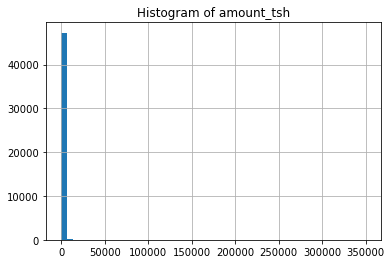

In [22]:
df['amount_tsh'].hist(bins=50)
plt.title('Histogram of amount_tsh');

'amount_tsh' is heavily skewed with zeros. A cursory internet search indicates 'amount_tsh' is a pump calculation and zero is a legitimate value. **Implicit nulls cannot be assumed here.**

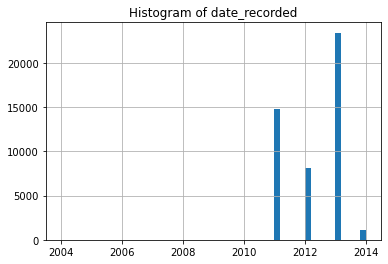

In [23]:
df['date_recorded'].hist(bins=50)
plt.title('Histogram of date_recorded');

Most recordings happened between 2011 and 2014, but there are a handful of recordings back to 2004. We have no reason to believe any date was used as a placeholder (and should be considered null). **Implicit nulls cannot be assumed here.**

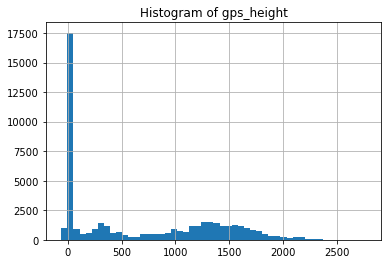

In [24]:
df['gps_height'].hist(bins=50)
plt.title('Histogram of gps_height');

'gps_height' is heavily skewed with zeros. Since 'gps_height' represents altitude, and zero represents sea level, it is reasonable to believe that zeros were used as placeholders. Latitude and longitude data could be used to cross-reference an altitude map to determine exact altitude for zero-coded wells, but 'dialing in' the accuracy of the data like this is not suited for an initial EDA. **Implicit nulls cannot be assumed here.**

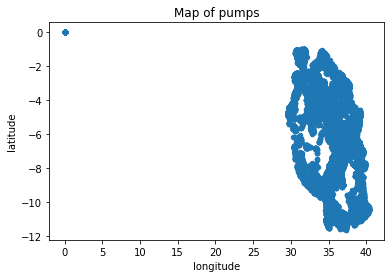

In [25]:
df.plot(x='longitude', y='latitude', kind='scatter')
plt.title('Map of pumps');

"Null Island" strikes again. These values need to be replaced with nulls.

In [26]:
# longitude values purged of zero
long_purged = df['longitude'][df['longitude'] > 0]
# latitude values purged of zero
lat_purged = df['latitude'][df['latitude'] < 0]

# confirm "Null Island" values purged
print(long_purged.min())
print(lat_purged.max())

29.6071219
-2e-08


Longitude values will be correct, but latitude still has values close to zero.

In [27]:
# latitude values purged of values close to zero
lat_purged = df['latitude'][df['latitude'] < -0.1]

# confirm "Null Island" values purged
print(lat_purged.max())

-0.99846435


Much better. These values should be set to null.

In [28]:
# replace close-to-zero values in longitude and latitude with nulls
df['longitude'].mask(df['longitude'].between(-0.1, 0.1), inplace=True)
df['latitude'].mask(df['latitude'].between(-0.1, 0.1), inplace=True)

In [29]:
# confirm replacement of chosen values
print(df['longitude'].min())
print(df['latitude'].max())

29.6071219
-0.99846435


In [30]:
# confirm replacement of chosen values with nulls
print(df['longitude'].notnull().value_counts())
print(df['latitude'].notnull().value_counts())

True     46087
False     1433
Name: longitude, dtype: int64
True     46087
False     1433
Name: latitude, dtype: int64


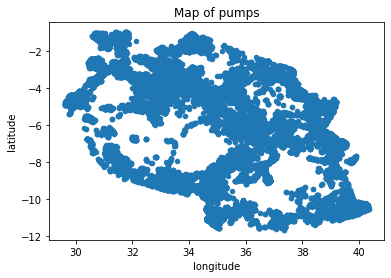

In [31]:
# re-plot longitude and latitude
df.plot(x='longitude', y='latitude', kind='scatter')
plt.title('Map of pumps');

That looks a lot more like Tanzania. **Implicit nulls have been assumed and replaced.**

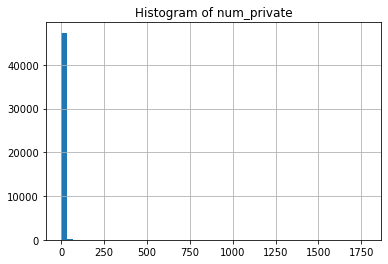

In [32]:
df['num_private'].hist(bins=50)
plt.title('Histogram of num_private');

'num_private' is heavily skewed with zeros. There is no description for 'num_private' with the dataset. There is not enough information to assume that this column is noise, at least for this first iteration of EDA, so it will not be removed from the dataset. **Implicit nulls cannot be assumed here.**

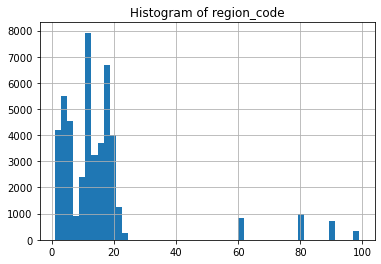

In [33]:
df['region_code'].hist(bins=50)
plt.title('Histogram of region_code');

'region_code' is categorical, and there are no zero-coded values. **Implicit nulls cannot be assumed here.**

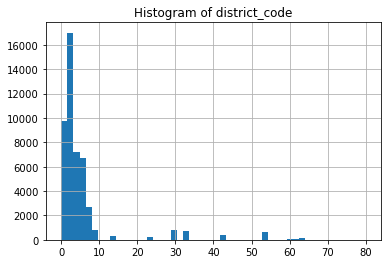

In [34]:
df['district_code'].hist(bins=50)
plt.title('Histogram of district_code');

In [35]:
df['district_code'].value_counts(ascending=True)

67       3
80       8
0       19
60      55
62      87
63     157
23     247
13     313
43     408
53     607
33     687
30     795
8      818
7     2663
6     3275
5     3467
4     7166
3     7999
2     8991
1     9755
Name: district_code, dtype: int64

'district_code' is categorical, but it does have some zero-coded values. There is not enough information to determine if a zero-coded district is a placeholder, or if zero is truly a district number. **Implicit nulls cannot be assumed here.**

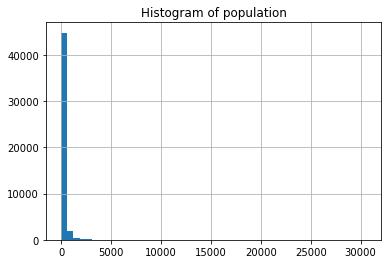

In [36]:
df['population'].hist(bins=50)
plt.title('Histogram of population');

'population' has plenty of zero-coded values, however, it is possible for a well to have a population of zero (well exists but there is no one in the area who uses it). We cannot differentiate between the wells which have a placeholder value of zero population and the wells which legitimately have zero population. **Implicit nulls cannot be assumed here.**

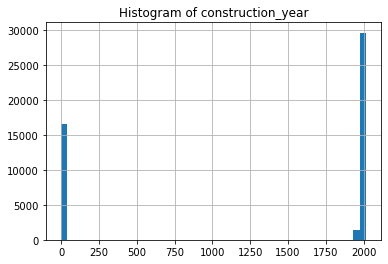

In [37]:
df['construction_year'].hist(bins=50)
plt.title('Histogram of construction_year');

There are zero-coded values in 'construction_year'. It is safe to assume that these wells weren't build at the start of the Common Era, so these wells don't have a 'construction_year' value. We will have to impute these values later. For now, we will replace zero-coded values with a null.

In [38]:
# replace zero-coded values with nulls
df['construction_year'].mask(df['construction_year'] == 0, inplace=True)

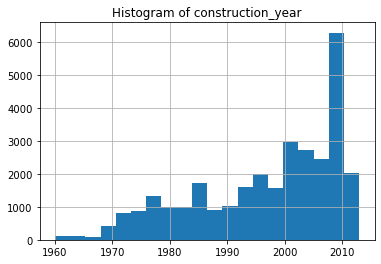

In [39]:
df['construction_year'].hist(bins=20)
plt.title('Histogram of construction_year');

**Implicit nulls have been assumed and replaced.**

It is also prudent to look through the object (text) columns to ensure that none of them have values that should be interpreted as null.

In [40]:
# select columns of object type
df_obj = df.select_dtypes('object')
df_obj.columns

Index(['status_group', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [41]:
# dataframe of object columns for easier viewing
df_obj = df[list(df_obj.columns)]
df_obj.head()

,status_group,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,functional,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,functional,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,non functional,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,non functional,NaN,NaN,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,non functional,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [42]:
# possible high cardinality columns
[f"Column: {obj}, Unique items: {df[obj].nunique()}" for obj in df_obj.columns if (df[obj].nunique() > 25)]

['Column: funder, Unique items: 1698',
 'Column: installer, Unique items: 1923',
 'Column: wpt_name, Unique items: 30742',
 'Column: subvillage, Unique items: 17232',
 'Column: lga, Unique items: 125',
 'Column: ward, Unique items: 2076']

In [43]:
# create list of low cardinality columns
high_card_cols = [obj for obj in df_obj.columns if (df[obj].nunique() > 25)]
low_card_cols = [obj for obj in df_obj.columns if obj not in high_card_cols]
low_card_cols.remove('status_group') # remove target variable
print(low_card_cols)

['basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [44]:
# list of unique values by low cardinality columns
[{obj: list(df_obj[obj].unique())} for obj in low_card_cols]

[{'basin': ['Internal',
   'Lake Rukwa',
   'Rufiji',
   'Wami / Ruvu',
   'Lake Victoria',
   'Lake Tanganyika',
   'Pangani',
   'Lake Nyasa',
   'Ruvuma / Southern Coast']},
 {'region': ['Manyara',
   'Dodoma',
   'Mbeya',
   'Morogoro',
   'Mwanza',
   'Shinyanga',
   'Kigoma',
   'Tanga',
   'Iringa',
   'Arusha',
   'Kagera',
   'Singida',
   'Tabora',
   'Rukwa',
   'Pwani',
   'Ruvuma',
   'Dar es Salaam',
   'Kilimanjaro',
   'Lindi',
   'Mtwara',
   'Mara']},
 {'public_meeting': [True, False, nan]},
 {'scheme_management': ['Water Board',
   'VWC',
   'WUG',
   nan,
   'Water authority',
   'Parastatal',
   'SWC',
   'WUA',
   'Private operator',
   'Company',
   'Other',
   'Trust',
   'None']},
 {'permit': [True, False, nan]},
 {'extraction_type': ['gravity',
   'india mark ii',
   'other',
   'nira/tanira',
   'swn 80',
   'mono',
   'submersible',
   'afridev',
   'ksb',
   'windmill',
   'other - rope pump',
   'other - swn 81',
   'other - play pump',
   'climax',
   'in

A quick glance through the low-cardinality columns reveals that nulls are already specified, or there are no values which should be interpreted as nulls. 'scheme_management' has a 'None' value, but it is unclear whether this is a null value or there is truly no scheme management for the pump, and the 'None' value would therefore be valid data.

### High Cardinality Categorical Columns (HCCCs)

HCCCs often have only a few rows of data for each variable. This is counterproductive to the generalizations that are needed for a machine learning model to operate effectively, and as such, are to be removed.

In [45]:
# possible HCCCs
[f"Column: {obj}, Unique items: {df[obj].nunique()}" for obj in df_obj.columns if (df[obj].nunique() > 25)]

['Column: funder, Unique items: 1698',
 'Column: installer, Unique items: 1923',
 'Column: wpt_name, Unique items: 30742',
 'Column: subvillage, Unique items: 17232',
 'Column: lga, Unique items: 125',
 'Column: ward, Unique items: 2076']

In [46]:
# number of values with single row for possible HCCCs
for obj in df_obj.columns:
    if df[obj].nunique() > 25:
        print(f"Number of single-row items for {obj}: {pd.Series(df[obj].value_counts() == 1).sum()}")

Number of single-row items for funder: 866
Number of single-row items for installer: 974
Number of single-row items for wpt_name: 27332
Number of single-row items for subvillage: 9012
Number of single-row items for lga: 1
Number of single-row items for ward: 44


'lga' is the only possible HCCC that could provide some benefit (all others are too high-cardinality).

In [47]:
df['lga'].value_counts(sort=True, ascending=True)[:25]

Nyamagana             1
Lindi Urban          16
Kigoma Urban         52
Arusha Urban         54
Moshi Urban          64
Songea Urban         66
Morogoro Urban       72
Bukoba Urban         73
Kinondoni            73
Tanga                79
Mtwara Urban         99
Mafia               105
Ilemela             107
Kilindi             123
Tabora Urban        123
Liwale              124
Singida Urban       129
Nanyumbu            129
Sikonge             137
Shinyanga Urban     150
Sumbawanga Urban    150
Kiteto              153
Ngorongoro          157
Tarime              157
Monduli             158
Name: lga, dtype: int64

The total sample sizes for each value in 'lga' can get very small (disregarding the one single-row value) but it may provide some value. 'lga' will be kept; all other HCCCs will be removed from the dataset.

In [48]:
# drop HCCCs from dataframe
hccc_list = ['funder', 'installer', 'wpt_name', 'subvillage', 'ward']
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=hccc_list, inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 38
Columns after removal: 33


### Duplicate Value Columns

Some of the column names suggest they are duplicate values (or close enough to be considered duplicates).

In [49]:
# list of column names
print(df.columns)

Index(['status_group', 'amount_tsh', 'date_recorded', 'gps_height',
       'longitude', 'latitude', 'num_private', 'basin', 'region',
       'region_code', 'district_code', 'lga', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')


Possible duplicates:
- 'extraction_type' and 'extraction_type_group' and 'extraction_type_class'
- 'management' and 'management_group'
- 'payment' and 'payment_type'
- 'water_quality' and 'quality_group'
- 'quantity' and 'quantity_group'
- 'source' and 'source_type' and 'source_class'
- 'waterpoint_type' and 'waterpoint_type_group'

In [50]:
# first 5 values of possible extraction type duplicates
extract_dups = ['extraction_type', 'extraction_type_group', 'extraction_type_class']
df[extract_dups].head()

,extraction_type,extraction_type_group,extraction_type_class
id,,,
454,gravity,gravity,gravity
510,india mark ii,india mark ii,handpump
14146,other,other,other
47410,gravity,gravity,gravity
1288,other,other,other


In [51]:
# unique values in possible extraction type duplicates
print([{col: df[col].unique()} for col in extract_dups])

[{'extraction_type': array(['gravity', 'india mark ii', 'other', 'nira/tanira', 'swn 80',
       'mono', 'submersible', 'afridev', 'ksb', 'windmill',
       'other - rope pump', 'other - swn 81', 'other - play pump',
       'climax', 'india mark iii', 'cemo', 'walimi',
       'other - mkulima/shinyanga'], dtype=object)}, {'extraction_type_group': array(['gravity', 'india mark ii', 'other', 'nira/tanira', 'swn 80',
       'mono', 'submersible', 'afridev', 'wind-powered', 'rope pump',
       'other handpump', 'other motorpump', 'india mark iii'],
      dtype=object)}, {'extraction_type_class': array(['gravity', 'handpump', 'other', 'motorpump', 'submersible',
       'wind-powered', 'rope pump'], dtype=object)}]


These are clearly duplicate columns, but it is unclear which column to keep. Each has their own benefits and drawbacks:
- 'extraction_type' has the highest quantity of unique values, making it useful for differentiation
- 'extraction_type_group' has a middling quantity; best of both worlds?
- 'extraction_type_class' has the lowest quantity of unique values, and is the easiest to understand from a layman's perspective

Perhaps knowing how many of each value will provide some clarity.

In [52]:
# count of rows with unique value for each extraction type column
{col: {val: df.loc[df[col] == val].count()[0] for val in df[col].unique()} for col in extract_dups}

{'extraction_type': {'gravity': 21340,
  'india mark ii': 1920,
  'other': 5150,
  'nira/tanira': 6566,
  'swn 80': 2965,
  'mono': 2284,
  'submersible': 3851,
  'afridev': 1409,
  'ksb': 1111,
  'windmill': 84,
  'other - rope pump': 376,
  'other - swn 81': 178,
  'other - play pump': 70,
  'climax': 28,
  'india mark iii': 71,
  'cemo': 74,
  'walimi': 41,
  'other - mkulima/shinyanga': 2},
 'extraction_type_group': {'gravity': 21340,
  'india mark ii': 1920,
  'other': 5150,
  'nira/tanira': 6566,
  'swn 80': 2965,
  'mono': 2284,
  'submersible': 4962,
  'afridev': 1409,
  'wind-powered': 84,
  'rope pump': 376,
  'other handpump': 291,
  'other motorpump': 102,
  'india mark iii': 71},
 'extraction_type_class': {'gravity': 21340,
  'handpump': 13222,
  'other': 5150,
  'motorpump': 2386,
  'submersible': 4962,
  'wind-powered': 84,
  'rope pump': 376}}

'extraction_type_group' appears to be the best choice. 'extraction_type' is too specific, with some value counts too low to be useful. 'extraction_type_class' is also an acceptable choice, but accumulates the values more than is necessary when compared to 'extraction_type_group'.

In [53]:
# drop 'extraction_type' and 'extraction_type_class' from dataframe
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=['extraction_type', 'extraction_type_class'], inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 33
Columns after removal: 31


In [54]:
# first 5 values of possible management duplicates
mgmt_dups = ['management', 'management_group']
df[mgmt_dups].head()

,management,management_group
id,,
454,water board,user-group
510,vwc,user-group
14146,vwc,user-group
47410,vwc,user-group
1288,vwc,user-group


In [55]:
# unique values in possible management duplicates
print([{col: df[col].unique()} for col in mgmt_dups])

[{'management': array(['water board', 'vwc', 'wug', 'private operator', 'parastatal',
       'other - school', 'wua', 'unknown', 'company', 'other',
       'water authority', 'trust'], dtype=object)}, {'management_group': array(['user-group', 'commercial', 'parastatal', 'other', 'unknown'],
      dtype=object)}]


In [56]:
# count of rows with unique value for each management column
{col: {val: df.loc[df[col] == val].count()[0] for val in df[col].unique()} for col in mgmt_dups}

{'management': {'water board': 2326,
  'vwc': 32455,
  'wug': 5204,
  'private operator': 1566,
  'parastatal': 1413,
  'other - school': 81,
  'wua': 2033,
  'unknown': 456,
  'company': 524,
  'other': 683,
  'water authority': 716,
  'trust': 63},
 'management_group': {'user-group': 42018,
  'commercial': 2869,
  'parastatal': 1413,
  'other': 764,
  'unknown': 456}}

'management' has some unique values with low counts ('trust' in particular) but that may be overshadowed by 'management_group' being heavily skewed in its value count of 'user_group'. 'management' is probably the better choice for that reason.

In [57]:
# drop 'management_group' from dataframe
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=['management_group'], inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 31
Columns after removal: 30


In [58]:
# first 5 values of possible payment duplicates
pay_dups = ['payment', 'payment_type']
print(df[pay_dups].head())
print('\n')
# unique values in possible payment duplicates
print([{col: df[col].unique()} for col in pay_dups])
print('\n')
# count of rows with unique value for each payment column
print({col: {val: df.loc[df[col] == val].count()[0] for val in df[col].unique()} for col in pay_dups})

                     payment payment_type
id                                       
454           pay per bucket   per bucket
510                never pay    never pay
14146              never pay    never pay
47410            pay monthly      monthly
1288   pay when scheme fails   on failure


[{'payment': array(['pay per bucket', 'never pay', 'pay monthly',
       'pay when scheme fails', 'other', 'pay annually', 'unknown'],
      dtype=object)}, {'payment_type': array(['per bucket', 'never pay', 'monthly', 'on failure', 'other',
       'annually', 'unknown'], dtype=object)}]


{'payment': {'pay per bucket': 7223, 'never pay': 20318, 'pay monthly': 6574, 'pay when scheme fails': 3154, 'other': 844, 'pay annually': 2886, 'unknown': 6521}, 'payment_type': {'per bucket': 7223, 'never pay': 20318, 'monthly': 6574, 'on failure': 3154, 'other': 844, 'annually': 2886, 'unknown': 6521}}


These are clear duplicates. 'payment' will be kept because the descriptions are clearer.

In [59]:
# drop 'payment_type' from dataframe
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=['payment_type'], inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 30
Columns after removal: 29


In [60]:
# first 5 values of possible quantity duplicates
quant_dups = ['quantity', 'quantity_group']
print(df[quant_dups].head())
print('\n')
# unique values in possible quantity duplicates
print([{col: df[col].unique()} for col in quant_dups])
print('\n')
# count of rows with unique value for each quantity column
print({col: {val: df.loc[df[col] == val].count()[0] for val in df[col].unique()} for col in quant_dups})

           quantity quantity_group
id                                
454    insufficient   insufficient
510          enough         enough
14146        enough         enough
47410  insufficient   insufficient
1288         enough         enough


[{'quantity': array(['insufficient', 'enough', 'seasonal', 'dry', 'unknown'],
      dtype=object)}, {'quantity_group': array(['insufficient', 'enough', 'seasonal', 'dry', 'unknown'],
      dtype=object)}]


{'quantity': {'insufficient': 12104, 'enough': 26538, 'seasonal': 3225, 'dry': 5024, 'unknown': 629}, 'quantity_group': {'insufficient': 12104, 'enough': 26538, 'seasonal': 3225, 'dry': 5024, 'unknown': 629}}


These are clear duplicates. 'quantity' will be kept.

In [61]:
# drop 'quantity_group' from dataframe
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=['quantity_group'], inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 29
Columns after removal: 28


In [62]:
# first 5 values of possible source duplicates
source_dups = ['source', 'source_type', 'source_class']
print(df[source_dups].head())
print('\n')
# unique values in possible source duplicates
print([{col: df[col].unique()} for col in source_dups])
print('\n')
# count of rows with unique value for each source column
print({col: {val: df.loc[df[col] == val].count()[0] for val in df[col].unique()} for col in source_dups})

             source   source_type source_class
id                                            
454          spring        spring  groundwater
510    shallow well  shallow well  groundwater
14146  shallow well  shallow well  groundwater
47410         river    river/lake      surface
1288   shallow well  shallow well  groundwater


[{'source': array(['spring', 'shallow well', 'river', 'machine dbh', 'hand dtw',
       'dam', 'rainwater harvesting', 'lake', 'other', 'unknown'],
      dtype=object)}, {'source_type': array(['spring', 'shallow well', 'river/lake', 'borehole', 'dam',
       'rainwater harvesting', 'other'], dtype=object)}, {'source_class': array(['groundwater', 'surface', 'unknown'], dtype=object)}]


{'source': {'spring': 13537, 'shallow well': 13540, 'river': 7719, 'machine dbh': 8849, 'hand dtw': 701, 'dam': 505, 'rainwater harvesting': 1829, 'lake': 606, 'other': 178, 'unknown': 56}, 'source_type': {'spring': 13537, 'shallow well': 13540, 'river/lake': 8325, 'borehole': 95

'source' and 'source_type' are duplicates, and 'source_class' is also a duplication to some extent, but it is unclear if only one of the three columns should be kept, or some combination with 'source_class'.

After some thought, 'source_class' is too general. Either 'source' or 'source_type' will be kept. 'source_type' groups the following categories from 'source':
- 'river' and 'lake' into 'river/lake'
- 'machine dbh' and 'hand dtw' into 'borehole'
- 'other' and 'unknown' into 'other'

There may be sufficient reason to keep these separate. Looking at the target variable by the separate types may clarify.

In [63]:
# target variable percentage total by source type ('river' and 'lake')
river_group_df = df.loc[df['source'] == 'river']['status_group'].value_counts(normalize=True) * 100
river_group_df.name = 'river'
lake_group_df = df.loc[df['source'] == 'lake']['status_group'].value_counts(normalize=True) * 100
lake_group_df.name = 'lake'
river_lake_df = pd.merge(river_group_df, lake_group_df, left_index=True, right_index=True)
print(river_lake_df)

                             river       lake
functional               56.380360  21.122112
non functional           31.001425  77.392739
functional needs repair  12.618215   1.485149


In [64]:
# target variable percentage total by source type ('machine dbh' and 'hand dtw')
machine_group_df = df.loc[df['source'] == 'machine dbh']['status_group'].value_counts(normalize=True) * 100
machine_group_df.name = 'machine_dbh'
hand_group_df = df.loc[df['source'] == 'hand dtw']['status_group'].value_counts(normalize=True) * 100
hand_group_df.name = 'hand_dtw'
mg_hand_df = pd.merge(machine_group_df, hand_group_df, left_index=True, right_index=True)
print(mg_hand_df)

                         machine_dbh   hand_dtw
functional                 49.282405  55.777461
non functional             46.276415  42.368046
functional needs repair     4.441180   1.854494


In [65]:
# target variable percentage total by source type ('other' and 'unknown')
other_group_df = df.loc[df['source'] == 'other']['status_group'].value_counts(normalize=True) * 100
other_group_df.name = 'other'
unknown_group_df = df.loc[df['source'] == 'unknown']['status_group'].value_counts(normalize=True) * 100
unknown_group_df.name = 'unknown'
other_unknown_df = pd.merge(other_group_df, unknown_group_df, left_index=True, right_index=True)
print(other_unknown_df)

                             other    unknown
functional               59.550562  48.214286
non functional           39.887640  46.428571
functional needs repair   0.561798   5.357143


In [66]:
# chi squared test for difference in 'river' and 'lake'
river_group_df = df.loc[df['source'] == 'river']['status_group'].value_counts()
river_group_df.name = 'river'
lake_group_df = df.loc[df['source'] == 'lake']['status_group'].value_counts()
lake_group_df.name = 'lake'
river_lake_df = pd.merge(river_group_df, lake_group_df, left_index=True, right_index=True)

_, p, _, _ = chi2_contingency(river_lake_df)
if p < 0.05:
    print(f'p value is {p}. Significant difference')
else:
    print(f'p value is {p}. Insignificant difference')

p value is 4.212322495122488e-118. Significant difference


The 'borehole' and 'other' combinations have little difference (just looking at the percentages) but there is a statistically significant difference between the target values in 'river' and 'lake'. For this reason, we will keep 'source'.

In [67]:
# drop 'source_type' and 'source_class' from dataframe
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=['source_type', 'source_class'], inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 28
Columns after removal: 26


In [68]:
# first 5 values of possible waterpoint type duplicates
wp_type_groups = ['waterpoint_type', 'waterpoint_type_group']
print(df[wp_type_groups].head())
print('\n')
# unique values in possible waterpoint type duplicates
print([{col: df[col].unique()} for col in wp_type_groups])
print('\n')
# count of rows with unique value for each waterpoint type column
print({col: {val: df.loc[df[col] == val].count()[0] for val in df[col].unique()} for col in wp_type_groups})

          waterpoint_type waterpoint_type_group
id                                             
454    communal standpipe    communal standpipe
510             hand pump             hand pump
14146               other                 other
47410  communal standpipe    communal standpipe
1288                other                 other


[{'waterpoint_type': array(['communal standpipe', 'hand pump', 'other',
       'communal standpipe multiple', 'improved spring', 'cattle trough',
       'dam'], dtype=object)}, {'waterpoint_type_group': array(['communal standpipe', 'hand pump', 'other', 'improved spring',
       'cattle trough', 'dam'], dtype=object)}]


{'waterpoint_type': {'communal standpipe': 22785, 'hand pump': 14073, 'other': 5098, 'communal standpipe multiple': 4830, 'improved spring': 639, 'cattle trough': 91, 'dam': 4}, 'waterpoint_type_group': {'communal standpipe': 27615, 'hand pump': 14073, 'other': 5098, 'improved spring': 639, 'cattle trough': 91, 'dam': 4}}


The only difference between 'waterpoint_type' and 'waterpoint_type_group' is the separation of 'communal standpipe' and 'communal standpipe multiple' in 'waterpoint_type'. The same target variable analysis from source type will be used here.

In [69]:
# target variable percentage total by waterpoint type ('communal standpipe' and 'communal standpipe multiple')
cs_group_df = (df.loc[df['waterpoint_type'] == 'communal standpipe']
               ['status_group'].value_counts(normalize=True) * 100
              )
cs_group_df.name = 'CS'
csm_group_df = (df.loc[df['waterpoint_type'] == 'communal standpipe multiple']
                ['status_group'].value_counts(normalize=True) * 100
               )
csm_group_df.name = 'CSM'
cs_csm_df = pd.merge(cs_group_df, csm_group_df, left_index=True, right_index=True)
print(cs_csm_df)

                                CS        CSM
functional               62.264648  36.397516
non functional           29.888084  52.919255
functional needs repair   7.847268  10.683230


In [70]:
# chi squared test for difference in 'communal standpipe' and 'communal standpipe multiple'
cs_group_df = df.loc[df['waterpoint_type'] == 'communal standpipe']['status_group'].value_counts()
cs_group_df.name = 'CS'
csm_group_df = df.loc[df['waterpoint_type'] == 'communal standpipe multiple']['status_group'].value_counts()
csm_group_df.name = 'CSM'
cs_csm_df = pd.merge(cs_group_df, csm_group_df, left_index=True, right_index=True)

_, p, _, _ = chi2_contingency(cs_csm_df)
if p < 0.05:
    print(f'p value is {p}. Significant difference')
else:
    print(f'p value is {p}. Insignificant difference')

p value is 1.0850696773302554e-244. Significant difference


There is a statistically significant difference between 'communal standpipe' and 'communal standpipe multiple'. For this reason, we will keep waterpoint_type.

In [71]:
# drop 'waterpoint_type_group' from dataframe
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=['waterpoint_type_group'], inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 26
Columns after removal: 25


In [72]:
# dataframe after EDA 1
print(df.shape)
df.head()

(47520, 25)


,status_group,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,...,permit,construction_year,extraction_type_group,management,payment,water_quality,quality_group,quantity,source,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,
454,functional,50.0,2013,2092,35.426020,-4.227446,0,Internal,Manyara,21,...,True,1998.0,gravity,water board,pay per bucket,soft,good,insufficient,spring,communal standpipe
510,functional,0.0,2011,0,35.510074,-5.724555,0,Internal,Dodoma,1,...,True,NaN,india mark ii,vwc,never pay,soft,good,enough,shallow well,hand pump
14146,non functional,0.0,2012,0,32.499866,-9.081222,0,Lake Rukwa,Mbeya,12,...,False,NaN,other,vwc,never pay,soft,good,enough,shallow well,other
47410,non functional,0.0,2011,0,34.060484,-8.830208,0,Rufiji,Mbeya,12,...,True,NaN,gravity,vwc,pay monthly,soft,good,insufficient,river,communal standpipe
1288,non functional,300.0,2011,1023,37.032690,-6.040787,0,Wami / Ruvu,Morogoro,5,...,True,1997.0,other,vwc,pay when scheme fails,salty,salty,enough,shallow well,other


## Feature Engineering 1

There is some feature engineering which can be done to better represent the data, while also reducing the number of columns.

As stated previously, a useful feature to engineer would be pump age, represented by: 
$$pump_{age} = date_{recorded} - date_{construction}$$

In [73]:
# feature engineering 'pump_age' column
df['pump_age'] = df['date_recorded'] - df['construction_year']
df['pump_age'][:10]

id
454      15.0
510       NaN
14146     NaN
47410     NaN
1288     14.0
13095     NaN
558       NaN
35626     2.0
8696      NaN
48650     4.0
Name: pump_age, dtype: float64

It's worth taking a quick look at our engineered column to make sure we don't have any glaring problems.

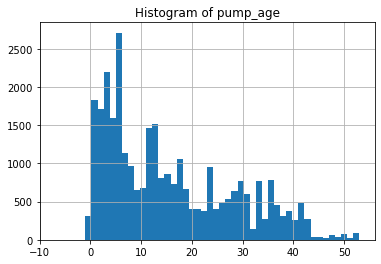

In [74]:
# Histogram of 'pump_age'
df['pump_age'].hist(bins=50)
plt.title('Histogram of pump_age');

It's suspicious that the histogram specifies a negative value; there is a possiblity that our feature engineering has generated negative values for 'pump_age' (which is impossible; a pump can't be negative years old!).

In [75]:
# rows with negative 'pump_age' values
df.loc[df['pump_age'] < 0][['date_recorded', 'construction_year', 'pump_age']]

,date_recorded,construction_year,pump_age
id,,,
15921,2004,2009.0,-5.0
5971,2004,2007.0,-3.0
53086,2004,2009.0,-5.0
20198,2004,2008.0,-4.0
9195,2004,2005.0,-1.0
48759,2004,2011.0,-7.0
20534,2004,2009.0,-5.0
1251,2005,2008.0,-3.0


As suspected. Clearly some of the data is inaccurate!

All of the values in 'date_recorded' are from 2004 (the oldest recordings. 2005 values have been rounded up from 2004). 2004 may have been used as a placeholder value, but that assumption is shaky when 'date_recorded' has specific values for 2004 (various months and years for recordings).

Most of the 'date_recorded' dates are from 2011 and later. It's worth looking at the small number of values prior to that.

In [76]:
# dates in 'date_recorded' earlier than 2011
df.loc[df['date_recorded'] < 2011]['date_recorded'].value_counts()

2005    15
2004     9
Name: date_recorded, dtype: int64

There is a small group of recordings from before 2011. It is unclear if these values or accurate or not; perhaps some of the values in 'construction_year' are inaccurate as well.

There are several approaches to the problem of negative values in 'pump_age'. The most clinical is to drop those rows, but dropping rows loses data in other columns that could be valuable. For now, the negative values will be converted to nulls, so as to preserve the other data.

In [77]:
# replace negative values in 'pump_age' with nulls
df['pump_age'].mask(df['pump_age'] < 0, inplace=True)

Since 'pump_age' has been engineered, 'date_recorded' and 'construction_year' are no longer needed.

In [78]:
# drop 'date_recorded' and 'construction_year'
print(f"Columns before removal: {df.shape[1]}")
df.drop(columns=['date_recorded', 'construction_year'], inplace=True)
print(f"Columns after removal: {df.shape[1]}")

Columns before removal: 26
Columns after removal: 24


In [79]:
# dataframe after feature engineering
print(df.shape)
print(df.info())
df.head()

(47520, 24)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           47520 non-null  object 
 1   amount_tsh             47520 non-null  float64
 2   gps_height             47520 non-null  int64  
 3   longitude              46087 non-null  float64
 4   latitude               46087 non-null  float64
 5   num_private            47520 non-null  int64  
 6   basin                  47520 non-null  object 
 7   region                 47520 non-null  object 
 8   region_code            47520 non-null  int64  
 9   district_code          47520 non-null  int64  
 10  lga                    47520 non-null  object 
 11  population             47520 non-null  int64  
 12  public_meeting         44831 non-null  object 
 13  scheme_management      44418 non-null  object 
 14  permit                 45081 non-null  o

,status_group,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,...,permit,extraction_type_group,management,payment,water_quality,quality_group,quantity,source,waterpoint_type,pump_age
id,,,,,,,,,,,,,,,,,,,,,
454,functional,50.0,2092,35.426020,-4.227446,0,Internal,Manyara,21,1,...,True,gravity,water board,pay per bucket,soft,good,insufficient,spring,communal standpipe,15.0
510,functional,0.0,0,35.510074,-5.724555,0,Internal,Dodoma,1,6,...,True,india mark ii,vwc,never pay,soft,good,enough,shallow well,hand pump,NaN
14146,non functional,0.0,0,32.499866,-9.081222,0,Lake Rukwa,Mbeya,12,6,...,False,other,vwc,never pay,soft,good,enough,shallow well,other,NaN
47410,non functional,0.0,0,34.060484,-8.830208,0,Rufiji,Mbeya,12,7,...,True,gravity,vwc,pay monthly,soft,good,insufficient,river,communal standpipe,NaN
1288,non functional,300.0,1023,37.032690,-6.040787,0,Wami / Ruvu,Morogoro,5,1,...,True,other,vwc,pay when scheme fails,salty,salty,enough,shallow well,other,14.0


## Data Wrangling 1

It is valuable in the course of EDA to consolidate differences between the starting data and the data after EDA. Should we receive more data in the format of the starting data, we will want to format it in the same way as the data after EDA, and having a data wrangling function will make this process easier.

In [80]:
def wrangle1(feature_path, target_path=None):
    # load data into dataframe
    if target_path:
        df = pd.merge(pd.read_csv(target_path).set_index('id'),
                pd.read_csv(feature_path).set_index('id'),
                left_index=True,
                right_index=True
                )
    else:
        df = pd.read_csv(feature_path).set_index('id')

    # convert 'date_recorded' to rounded year integer
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    def round_date_to_nearest_year(dt):
        if dt.month <= 6:
            return dt.year
        else:
            return dt.year + 1
    df['date_recorded'] = df['date_recorded'].map(round_date_to_nearest_year)

    # replace close-to-zero values in longitude and latitude with nulls
    df['longitude'].mask(df['longitude'].between(-0.1, 0.1), inplace=True)
    df['latitude'].mask(df['latitude'].between(-0.1, 0.1), inplace=True)

    # replace zero-coded values in 'construction_year' with nulls
    df['construction_year'].mask(df['construction_year'] == 0, inplace=True)

    # drop single value column
    df.drop(columns=['recorded_by'], inplace=True)

    # drop columns with too many nulls
    df.drop(columns=['scheme_name'], inplace=True)

    # drop HCCCs
    df.drop(columns=['funder',
                     'installer',
                     'wpt_name',
                     'subvillage',
                     'ward'],
            inplace=True
            )

    # drop duplicate columns
    df.drop(columns=['extraction_type',
                     'extraction_type_class',
                     'management_group',
                     'payment_type',
                     'quantity_group',
                     'source_type',
                     'source_class',
                     'waterpoint_type_group'], 
            inplace=True
            )

    # feature engineering 'pump_age' column
    df['pump_age'] = df['date_recorded'] - df['construction_year']
    # replace negative values in 'pump_age' with nulls
    df['pump_age'].mask(df['pump_age'] < 0, inplace=True)
    # drop 'date_recorded' and 'construction_year'
    df.drop(columns=['date_recorded', 'construction_year'], inplace=True)  

    return df

In [81]:
# dataframe after wrangle (should match dataframe after EDA and feature engineering)
df = wrangle1('train_features.csv', 'train_labels.csv')
print(df.shape)
print(df.info())
df.head()

(47520, 24)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           47520 non-null  object 
 1   amount_tsh             47520 non-null  float64
 2   gps_height             47520 non-null  int64  
 3   longitude              46087 non-null  float64
 4   latitude               46087 non-null  float64
 5   num_private            47520 non-null  int64  
 6   basin                  47520 non-null  object 
 7   region                 47520 non-null  object 
 8   region_code            47520 non-null  int64  
 9   district_code          47520 non-null  int64  
 10  lga                    47520 non-null  object 
 11  population             47520 non-null  int64  
 12  public_meeting         44831 non-null  object 
 13  scheme_management      44418 non-null  object 
 14  permit                 45081 non-null  o

,status_group,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,...,permit,extraction_type_group,management,payment,water_quality,quality_group,quantity,source,waterpoint_type,pump_age
id,,,,,,,,,,,,,,,,,,,,,
454,functional,50.0,2092,35.426020,-4.227446,0,Internal,Manyara,21,1,...,True,gravity,water board,pay per bucket,soft,good,insufficient,spring,communal standpipe,15.0
510,functional,0.0,0,35.510074,-5.724555,0,Internal,Dodoma,1,6,...,True,india mark ii,vwc,never pay,soft,good,enough,shallow well,hand pump,NaN
14146,non functional,0.0,0,32.499866,-9.081222,0,Lake Rukwa,Mbeya,12,6,...,False,other,vwc,never pay,soft,good,enough,shallow well,other,NaN
47410,non functional,0.0,0,34.060484,-8.830208,0,Rufiji,Mbeya,12,7,...,True,gravity,vwc,pay monthly,soft,good,insufficient,river,communal standpipe,NaN
1288,non functional,300.0,1023,37.032690,-6.040787,0,Wami / Ruvu,Morogoro,5,1,...,True,other,vwc,pay when scheme fails,salty,salty,enough,shallow well,other,14.0


## Baseline

Since the metric used for analysis in this notebook is classification accuracy, a fair baseline would be the accuracy if all wells were classified to the status with the highest overall percentage in the dataset.

In [82]:
# percentage of wells by 'status_group'
df['status_group'].value_counts(normalize=True)

functional                 0.542971
non functional             0.384091
functional needs repair    0.072938
Name: status_group, dtype: float64

The highest percentage status is 'functional' with 54.2971%. This will be the baseline accuracy.

## Machine Learning 1

### Note on Accuracy Metric
There are two sets of features (data) and targets (well status). The training set is fully available, and is used throughout this analysis. The testing features are provided ("test_features.csv") but the testing targets are hidden on Kaggle and are unavailable for use. In lieu of verification for the predictions of the final model operating on the testing features, this analysis will use the mean cross-validation accuracy score across 10 folds on the training data as an accuracy metric.

### Split Features and Targets

Before running the machine learning models, the features and target variables must be split.

In [83]:
# separate feature matrix and target vector
X = df.drop(columns=['status_group'])
y = df['status_group']

### Machine Learning Models 1

There are a number of machine learning models that are usable for classification. The first round of model building will use default values to get a general idea for which models are most accurate. These models will be tested:
1. Multinomial Logistic Regression
2. Decision Tree Classifier
3. Random Forest Classifier
4. XGBoost Classifier

For the first set of models, a simple ordinal encoder will be used to encode the categorical features, and a simple imputer (single imputing type) will be used to impute null values.

In [84]:
# Multinomial Logistic Regression Model
model_mlr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression(multi_class='multinomial', random_state=42, n_jobs=-1)
)

In [85]:
# Decision Tree Classifier Model
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

In [86]:
# Random Forest Classifier Model
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

In [87]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=-1)
)

In [88]:
# cross validation for multinomial logistic regression
cv_score_mlr = cross_val_score(model_mlr, X, y, cv=10, n_jobs=-1)

In [89]:
# cross validation for decision tree classifier
cv_score_dt = cross_val_score(model_dt, X, y, cv=10, n_jobs=-1)

In [90]:
# cross validation for random forest classifier
cv_score_rf = cross_val_score(model_rf, X, y, cv=10, n_jobs=-1)

In [91]:
cv_score_xgb = cross_val_score(model_xgb, X, y, cv=10, n_jobs=-1)

In [92]:
# scores for each model
print("MLR cross validation mean accuracy:", cv_score_mlr.mean())
print("MLR cross validation standard deviation:", cv_score_mlr.std())
print('\n')
print("Decision Tree cross validation mean accuracy:", cv_score_dt.mean())
print("Decision Tree cross validation standard deviation:", cv_score_dt.std())
print('\n')
print("Random Forest cross validation mean accuracy:", cv_score_rf.mean())
print("Random Forest validation standard deviation:", cv_score_rf.std())
print('\n')
print("XGBoost cross validation mean accuracy:", cv_score_xgb.mean())
print("XGBoost validation standard deviation:", cv_score_xgb.std())

MLR cross validation mean accuracy: 0.595138888888889
MLR cross validation standard deviation: 0.020479914312686046


Decision Tree cross validation mean accuracy: 0.7522306397306397
Decision Tree cross validation standard deviation: 0.0055606547356612055


Random Forest cross validation mean accuracy: 0.8014309764309765
Random Forest validation standard deviation: 0.004260207371085711


XGBoost cross validation mean accuracy: 0.7934764309764311
XGBoost validation standard deviation: 0.0025361018342058604


The accuracy results are clearly in favor of the tree-based classifiers. Each has its own perks and drawbacks:
- Decision tree is easier to "see into": a flowchart can be created to see the decisions (variables) in the data which have the most impact.
- Random forest ensemble is likely to produce more accurate results due to the majority voting structure.
- XGBoost, through iterations, has the greatest capacity to hone its ability to categorize accurately.

All three methods benefit from hyperparameter tuning, though XGBoost is the most likely to see a considerable increase, as its "out-of-the-box" analysis is generally lacking compared to its counterparts.

### Model Analysis 1

Though these simple models have not yet been tuned, it is worth exploring what features they deem to be most important in determining well status.

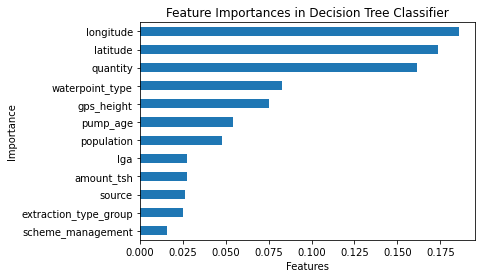

In [93]:
# Make a horizontal bar chart of the most important features in decision tree model
model_dt.fit(X, y)
features = X.columns
importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
feat_imp = pd.Series(data= importances, index= features).sort_values(key= abs).tail(12).plot(kind= 'barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Decision Tree Classifier');

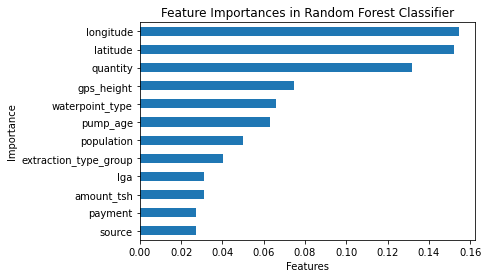

In [94]:
# Make a horizontal bar chart of the most important features in random forest model
model_rf.fit(X, y)
features = X.columns
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feat_imp = pd.Series(data= importances, index= features).sort_values(key= abs).tail(12).plot(kind= 'barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest Classifier');

[15:36:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


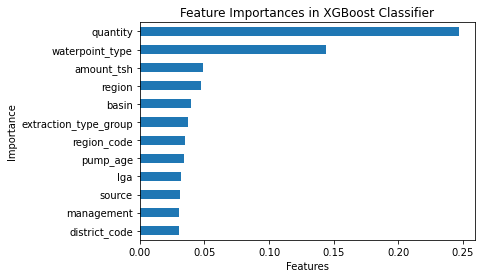

In [95]:
# Make a horizontal bar chart of the most important features in xgboost model
model_xgb.fit(X, y)
features = X.columns
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feat_imp = pd.Series(data= importances, index= features).sort_values(key= abs).tail(12).plot(kind= 'barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in XGBoost Classifier');

An interesting result! Both of the standard tree classifiers deem geographical location to be the strongest indicator of well status. The XGBoost classifier, however, seems to think geographical location is irrelevant compared to some other features.

Among all three models, quantity and waterpoint type score highly (within top 5 in all models). Pump age is also a significant indicator, although the XGBoost model does not rate it as highly as the standard tree classifiers.

### Hyperparameter Tuning 1

The out-of-the-box models are providing reasonable results, but squeezing out any additional accuracy is a plus. It's worth tweaking some of the internal levers and knobs inside the models to make its predictions more accurate and robust.

For all models, the accuracy may benefit from imputing methods other than 'mean'. The model will be allowed to decide which method works best.

#### Decision Tree

For the decision tree model, a handful of methods should provide the most benefit when tuned:
1. min_samples_leaf: restricts the total number of samples a final grouping must have. The model will make fewer decisions with a greater min_samples_leaf, preventing overfitting.
2. max_depth: restricts the number of decisions the tree can make along any particular branch. Works in conjunction with min_samples_leaf and prevents overfitting.
3. class_weight: changes how the model favors one classification over another. Since the classifications are mildly imbalanced, the model may benefit from weight balancing.

In [96]:
# DECISION TREE
# set parameter grid for search
param_grid = {
    'simpleimputer__strategy' : ['mean', 'median', 'most_frequent'],
    'decisiontreeclassifier__min_samples_leaf' : [1, 10, 50, 100],
    'decisiontreeclassifier__max_depth' : [10, 20, 50, 100],
    'decisiontreeclassifier__class_weight' : [None, 'balanced']
}

# grid search on best set of parameter combinations
model_dt_gs = GridSearchCV(
    model_dt,
    param_grid= param_grid,
    n_jobs=-1,
    cv=10
)
model_dt_gs.fit(X, y)

# show best result
print(model_dt_gs.best_score_)
print(model_dt_gs.best_params_)

0.7678872053872053
{'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__min_samples_leaf': 10, 'simpleimputer__strategy': 'most_frequent'}


A minor increase in accuracy. Decision Tree does not measure up to the base accuracies of the other models.

#### Random Forest

The Random Forest model will most benefit from the following parameters:
1. n_estimators: total number of trees voting. Increases accuracy at the cost of computational power. Too many trees may cause overfitting.
2. min_samples_leaf: same reasoning as with Decision Tree.
3. class_weight: same reasoning as with Decision Tree.
4. max_samples: determines the total number of samples a tree can use for training. A good max_samples can find create a diverse set of trees while giving them enough samples to make intelligent predictions.

In [97]:
# RANDOM FOREST
# set parameter grid for search
param_grid = {
    'simpleimputer__strategy' : ['mean', 'median', 'most_frequent'],
    'randomforestclassifier__n_estimators' : [100, 150, 200],
    # 'randomforestclassifier__min_samples_leaf' : [1, 10, 20, 50],
    # 'randomforestclassifier__class_weight' : [None, 'balanced', 'balanced_subsample'],
    'randomforestclassifier__max_samples' : [None, 8000, 16000, 24000]
}

# grid search on best set of parameter combinations
model_rf_gs = GridSearchCV(
    model_rf,
    param_grid= param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1
)
model_rf_gs.fit(X, y)

# show best result
print(model_rf_gs.best_score_)
print(model_rf_gs.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.804313973063973
{'randomforestclassifier__max_samples': 16000, 'randomforestclassifier__n_estimators': 200, 'simpleimputer__strategy': 'mean'}


A minor increase in accuracy. However, further tuning may provide even greater accuracy.

#### XGBoost

The XGBoost model will most benefit from the following parameters:
1. n_estimators: the number of iterations the decision tree will go through. An ideal n_estimators prevents overfitting or underfitting.
2. learning_rate: how much weight the tree applies to its innaccurate predictions. Too high a learning rate will cause the model to always overshoot the optimal prediction. Too low, and the model may undershoot.
3. max_depth: same reasoning as Decision Tree and Random Forest.

In [98]:
# XGBOOST
# set parameter grid for search
param_grid = {
    'simpleimputer__strategy' : ['mean', 'median', 'most_frequent'],
    'xgbclassifier__n_estimators' : [100, 200, 300],
    'xgbclassifier__learning_rate' : [0.15, 0.2, 0.25],
    'xgbclassifier__max_depth' : range(8, 13)
}

# randomized search on best set of parameter combinations
model_xgb_gs = RandomizedSearchCV(
    model_xgb,
    param_distributions= param_grid,
    n_iter= 10,
    n_jobs=-1,
    cv=5,
    verbose=1
)
model_xgb_gs.fit(X, y)

# show best result
print(model_xgb_gs.best_score_)
print(model_xgb_gs.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:42:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8037247474747474
{'xgbclassifier__n_estimators': 300, 'xgbclassifier__max_depth': 9, 'xgbclassifier__learning_rate': 0.15, 'simpleimputer__strategy': 'median'}


A decent accuracy, but the greatest increase over the base model.